# Jaya Haryono Manik - Del Institute of Technology #


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn
    * Keras / Tensorflow
    * ImbLearn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

## Bank Credit scoring ##

#### Description of the dataset

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years. The goal of this challenge is to build a model that borrowers can use to help make the best financial decisions.

* Twelve (520) attributes (dimensions). 
* The first attribute (Unamed : 0) contains the consumer ID which allows you to associate a data point with an a. consumer.
* The next attributes (1-11) is independent variable(X). 
* The 0 attributes (`SeriousDlqin2yrs`) is dependent variable(Y). indicate delinquent the customer.

The Dataset file consists of:
* cs-training.csv, which will be used as data training and data validation for training model and validate model.
* cs-test.csv, which will be used as data test to predict Y_test

A credit card default occurs when you completely override your credit card payment.

### 1. Dataset Exploration

#### Library Import

In [1]:
from __future__ import print_function, division
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from fancyimpute import KNN, SoftImpute
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Utility Function

In [2]:
# summarize history for accuracy
def plot_accuracy_against_epoch(model):
    plt.plot(model.history['acc'])
    plt.plot(model.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylim(0, 1)
    plt.show()

# summarize history for loss
def plot_loss_against_epoch(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylim(0, 1)
    plt.show()
# Count Number of points each class
def calculate_num_of_class(Y_train):
    yes = 0
    no = 0
    for i in Y_train:
        if i == 0:
            no = no +1
        else:
            yes = yes +1
    print("Count Labels : 1 = {}".format(yes))
    print("Count Labels : 0 = {}".format(no))

#### 1.1 Load Datasets

In [272]:
training_dataset = pd.read_csv('datasets/cs-training.csv', delimiter = ',').drop('Unnamed: 0', axis = 1)
test_dataset = pd.read_csv('datasets/cs-test.csv', delimiter = ',').drop('Unnamed: 0', axis = 1)
print("Dataset Size")
print("Training Size : {}".format(training_dataset.shape))
print("Test Size : {}".format(test_dataset.shape))

Dataset Size
Training Size : (150000, 11)
Test Size : (101503, 11)


#### 1.2 Inspect Dataset

In [4]:
training_dataset.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [5]:
test_dataset.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [6]:
training_dataset.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


In [7]:
training_dataset.tail(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
149990,0,0.055518,46,0,0.609779,4335.0,7,0,1,0,2.0
149991,0,0.104112,59,0,0.477658,10316.0,10,0,2,0,0.0
149992,0,0.871976,50,0,4132.000000,NaN,11,0,1,0,3.0
149993,0,1.000000,22,0,0.000000,820.0,1,0,0,0,0.0
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0
149999,0,0.850283,64,0,0.249908,8158.0,8,0,2,0,0.0


In [8]:
test_dataset.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0
5,NaN,0.509791,63,0,0.342429,4140.0,4,0,0,0,1.0
6,NaN,0.587778,50,0,1048.000000,0.0,5,0,0,0,3.0
7,NaN,0.046149,79,1,0.369170,3301.0,8,0,1,0,1.0
8,NaN,0.013527,68,0,2024.000000,NaN,4,0,1,0,0.0
9,NaN,1.000000,23,98,0.000000,0.0,0,98,0,98,0.0


In [9]:
test_dataset.tail(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
101493,NaN,0.035549,58,0,0.290323,11128.0,7,0,2,0,2.0
101494,NaN,0.218356,56,0,0.295803,1500.0,3,0,0,0,0.0
101495,NaN,0.718874,35,1,0.308047,4125.0,8,0,0,1,2.0
101496,NaN,0.021654,78,0,18.000000,NaN,8,0,0,0,0.0
101497,NaN,0.045230,67,0,0.012198,5000.0,4,0,0,0,0.0
101498,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0
101499,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0
101500,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN
101501,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0
101502,NaN,0.441842,29,0,0.198918,5916.0,12,0,0,0,0.0


In the dataset there are 150000 data points on the Training and 101503 data points on the Test with 12 attributes, namely:
* SeriousDlqin2yrs, Person experienced 90 days past due delinquency or worse (Y/N)
* RevolvingUtilizationOfUnsecuredLines, Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits(percentage)
* age, Age of borrower in years(integer)
* NumberOfTime30-59DaysPastDueNotWorse, Number of times borrower has been 30-59 days past due but no worse in the last 2 years(integer)
* DebtRatio, Monthly debt payments, alimony,living costs divided by monthy gross income(percentage)
* MonthlyIncome, Monthly income(real)
* NumberOfOpenCreditLinesAndLoans, Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)(integer)
* NumberOfTimes90DaysLate, Number of times borrower has been 90 days or more past due(integer)
* NumberRealEstateLoansOrLines, Number of mortgage and real estate loans including home equity lines of credit(integer)
* NumberOfTime60-89DaysPastDueNotWorse, Number of times borrower has been 60-89 days past due but no worse in the last 2 years(integer)
* NumberOfDependents, Number of dependents in family excluding themselves (spouse, children etc.) (integer)

In [10]:
training_dataset.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


From the table in the description of the feature, especially from the value of a feature, whether valid or not. example on the age feature, the minimum value of 0 (zero) indicating an invalid value for applying for a credit. Next from the dataset will be experimental features engineering to get good features from the dataset

#### 1.3 Preprocess Datasets

Impute Row that have missing value using SoftImpute Rather than SimpleImputer(mean, median and modus) and KNN

In [273]:
training_dataset.iloc[:,:] = SoftImpute().complete(training_dataset)
training_dataset = training_dataset.round({'age': 0, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'NumberOfOpenCreditLinesAndLoans':0,
                            'NumberOfTimes90DaysLate':0, 'NumberRealEstateLoansOrLines':0, 'NumberOfTime60-89DaysPastDueNotWorse':0,
                            'NumberOfDependents':0})

[SoftImpute] Max Singular Value of X_init = 5498797.118084
[SoftImpute] Iter 1: observed MAE=20.096280 rank=2


C:\ProgramData\Anaconda3\lib\site-packages\fancyimpute-0.3.1-py3.6.egg\fancyimpute\soft_impute.py:100: RuntimeWarning: divide by zero encountered in double_scalars


[SoftImpute] Iter 2: observed MAE=20.096333 rank=2
[SoftImpute] Iter 3: observed MAE=20.096341 rank=2
[SoftImpute] Iter 4: observed MAE=20.096345 rank=2
[SoftImpute] Iter 5: observed MAE=20.096348 rank=2
[SoftImpute] Iter 6: observed MAE=20.096352 rank=2
[SoftImpute] Iter 7: observed MAE=20.096355 rank=2
[SoftImpute] Iter 8: observed MAE=20.096358 rank=2
[SoftImpute] Iter 9: observed MAE=20.096361 rank=2
[SoftImpute] Iter 10: observed MAE=20.096364 rank=2
[SoftImpute] Iter 11: observed MAE=20.096367 rank=2
[SoftImpute] Iter 12: observed MAE=20.096369 rank=2
[SoftImpute] Iter 13: observed MAE=20.096372 rank=2
[SoftImpute] Iter 14: observed MAE=20.096375 rank=2
[SoftImpute] Iter 15: observed MAE=20.096378 rank=2
[SoftImpute] Iter 16: observed MAE=20.096380 rank=2
[SoftImpute] Iter 17: observed MAE=20.096383 rank=2
[SoftImpute] Iter 18: observed MAE=20.096385 rank=2
[SoftImpute] Iter 19: observed MAE=20.096388 rank=2
[SoftImpute] Iter 20: observed MAE=20.096390 rank=2
[SoftImpute] Iter 21

In [274]:
test_dataset.iloc[:,1:] = SoftImpute().complete(test_dataset.iloc[:,1:])
test_dataset = test_dataset.round({'age': 0, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'NumberOfOpenCreditLinesAndLoans':0,
                            'NumberOfTimes90DaysLate':0, 'NumberRealEstateLoansOrLines':0, 'NumberOfTime60-89DaysPastDueNotWorse':0,
                            'NumberOfDependents':0})

[SoftImpute] Max Singular Value of X_init = 10598115.191638
[SoftImpute] Iter 1: observed MAE=32.035881 rank=2
[SoftImpute] Iter 2: observed MAE=32.035890 rank=2


C:\ProgramData\Anaconda3\lib\site-packages\fancyimpute-0.3.1-py3.6.egg\fancyimpute\soft_impute.py:100: RuntimeWarning: divide by zero encountered in double_scalars


[SoftImpute] Iter 3: observed MAE=32.035891 rank=2
[SoftImpute] Iter 4: observed MAE=32.035891 rank=2
[SoftImpute] Iter 5: observed MAE=32.035891 rank=2
[SoftImpute] Iter 6: observed MAE=32.035891 rank=2
[SoftImpute] Iter 7: observed MAE=32.035892 rank=2
[SoftImpute] Iter 8: observed MAE=32.035892 rank=2
[SoftImpute] Iter 9: observed MAE=32.035892 rank=2
[SoftImpute] Iter 10: observed MAE=32.035893 rank=2
[SoftImpute] Iter 11: observed MAE=32.035893 rank=2
[SoftImpute] Iter 12: observed MAE=32.035893 rank=2
[SoftImpute] Iter 13: observed MAE=32.035893 rank=2
[SoftImpute] Iter 14: observed MAE=32.035894 rank=2
[SoftImpute] Iter 15: observed MAE=32.035894 rank=2
[SoftImpute] Iter 16: observed MAE=32.035894 rank=2
[SoftImpute] Iter 17: observed MAE=32.035894 rank=2
[SoftImpute] Iter 18: observed MAE=32.035894 rank=2
[SoftImpute] Iter 19: observed MAE=32.035895 rank=2
[SoftImpute] Iter 20: observed MAE=32.035895 rank=2
[SoftImpute] Iter 21: observed MAE=32.035895 rank=2
[SoftImpute] Iter 2

Remove Row that have invalid age (age == 0)

In [275]:
training_dataset = training_dataset[training_dataset.age != 0]
training_dataset = training_dataset.reset_index()

In [163]:
training_dataset.head(10)

,index,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,WorkerStatus,NewWorker,PrimeWorker,PeakWorker,Retired,TotalNumberOfOpenCredit,TotalNumberOfTime,IsDefaulted
0,0,1.0,-0.021150,45.0,2.0,-0.172834,0.286747,13.0,0.0,6.0,0.0,2.0,2,0.0,0.0,1.0,0.0,19.0,2.0,1.0
1,1,0.0,-0.020385,40.0,0.0,-0.173168,-0.209003,4.0,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,0.0,4.0,0.0,0.0
2,2,0.0,-0.021582,38.0,1.0,-0.173186,-0.175395,2.0,1.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,2.0,2.0,1.0
3,3,0.0,-0.023281,30.0,0.0,-0.173210,-0.155778,5.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,5.0,0.0,0.0
4,4,0.0,-0.020585,49.0,1.0,-0.173216,4.428232,7.0,0.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,8.0,1.0,1.0
5,5,0.0,-0.023364,74.0,0.0,-0.173044,-0.140571,3.0,0.0,1.0,0.0,1.0,3,0.0,0.0,0.0,1.0,4.0,0.0,0.0
6,6,0.0,-0.022994,57.0,0.0,2.628788,-0.406517,8.0,0.0,3.0,0.0,0.0,1,0.0,1.0,0.0,0.0,11.0,0.0,0.0
7,7,0.0,-0.021197,39.0,0.0,-0.173125,-0.140571,8.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,8.0,0.0,0.0
8,8,0.0,-0.023749,27.0,0.0,-0.150655,-0.406572,2.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,2.0,0.0,0.0
9,9,0.0,-0.023460,57.0,0.0,-0.172931,1.394124,9.0,0.0,4.0,0.0,2.0,1,0.0,1.0,0.0,0.0,13.0,0.0,0.0


In [235]:
test_dataset.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,NaN,0.885519,43.0,0.0,0.177513,5700.000000,4.0,0.0,0.0,0.0,0.0
1,NaN,0.463295,57.0,0.0,0.527237,9141.000000,15.0,0.0,4.0,0.0,2.0
2,NaN,0.043275,59.0,0.0,0.687648,5083.000000,12.0,0.0,1.0,0.0,2.0
3,NaN,0.280308,38.0,1.0,0.925961,3200.000000,7.0,0.0,2.0,0.0,0.0
4,NaN,1.000000,27.0,0.0,0.019917,3865.000000,4.0,0.0,0.0,0.0,1.0
5,NaN,0.509791,63.0,0.0,0.342429,4140.000000,4.0,0.0,0.0,0.0,1.0
6,NaN,0.587778,50.0,0.0,1048.000000,0.000000,5.0,0.0,0.0,0.0,3.0
7,NaN,0.046149,79.0,1.0,0.369170,3301.000000,8.0,0.0,1.0,0.0,1.0
8,NaN,0.013527,68.0,0.0,2024.000000,0.725155,4.0,0.0,1.0,0.0,0.0
9,NaN,1.000000,23.0,98.0,0.000000,0.000000,0.0,98.0,0.0,98.0,0.0


##### 1.4 Data Visualization

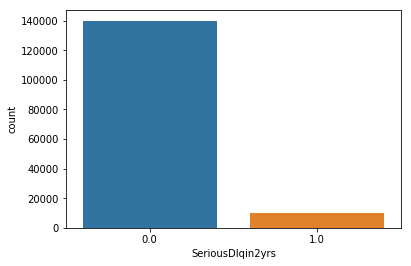

In [13]:
sns.countplot(training_dataset["SeriousDlqin2yrs"],label="Count") 

From the plot it is concluded that Delinquent and not Delinquent Customer is not balanced at all, this dataset potentially resulting in the classifier that ignores the fewer classes (in this case class 1).
generally, there are three method for handling imbalanced data, such as under sampling, over sampling and the combination of both. under sampling decreases the amount of dominant class (in this case class 0) so it will be balanced, whereas oversampling increases the amount of non dominant class (in this case class 1)

In [15]:
count = training_dataset.SeriousDlqin2yrs.value_counts()
print(count)
print("Perbandingan jumlah data setiap kelas = {} : {}".format((count[0]/count[1]),1))

0.0    139973
1.0     10026
Name: SeriousDlqin2yrs, dtype: int64
Perbandingan jumlah data setiap kelas = 13.96100139636944 : 1


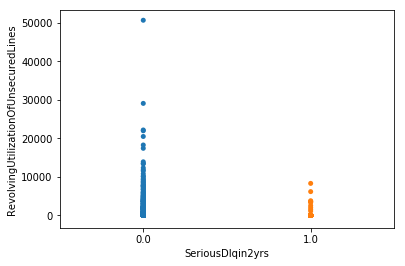

In [16]:
sns.stripplot(y="RevolvingUtilizationOfUnsecuredLines", x="SeriousDlqin2yrs", data=training_dataset);

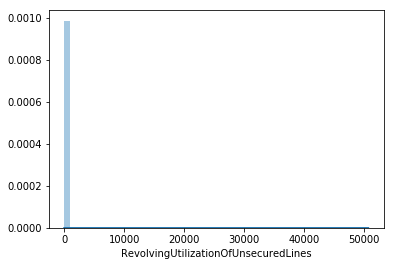

In [17]:
sns.distplot(training_dataset.RevolvingUtilizationOfUnsecuredLines)

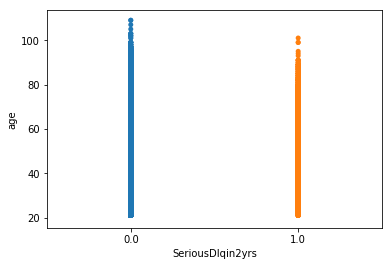

In [18]:
sns.stripplot(y="age", x="SeriousDlqin2yrs", data=training_dataset);

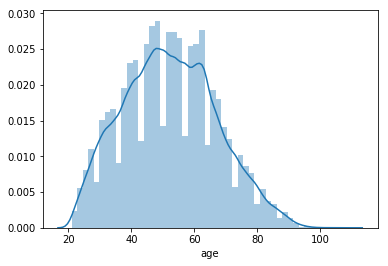

In [19]:
sns.distplot(training_dataset.age)

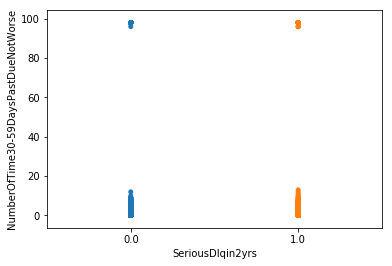

In [20]:
sns.stripplot(y="NumberOfTime30-59DaysPastDueNotWorse", x="SeriousDlqin2yrs", data=training_dataset);

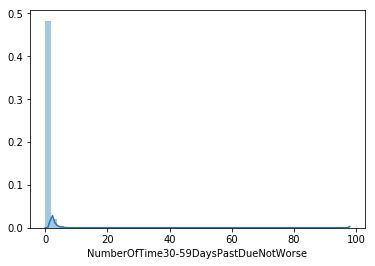

In [21]:
sns.distplot(training_dataset['NumberOfTime30-59DaysPastDueNotWorse'])

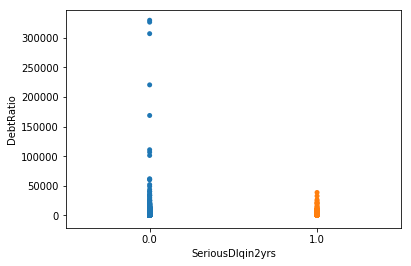

In [22]:
sns.stripplot(y="DebtRatio", x="SeriousDlqin2yrs", data=training_dataset);

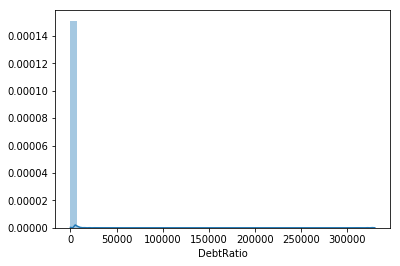

In [23]:
sns.distplot(training_dataset.DebtRatio)

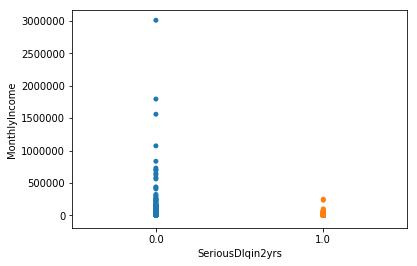

In [24]:
sns.stripplot(y="MonthlyIncome", x="SeriousDlqin2yrs", data=training_dataset);

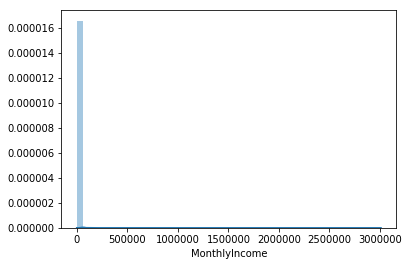

In [25]:
sns.distplot(training_dataset.MonthlyIncome)

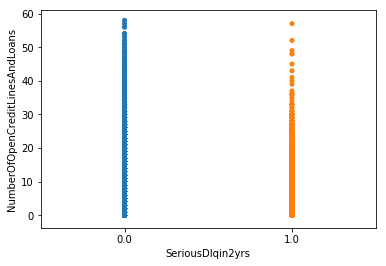

In [26]:
sns.stripplot(y="NumberOfOpenCreditLinesAndLoans", x="SeriousDlqin2yrs", data=training_dataset);

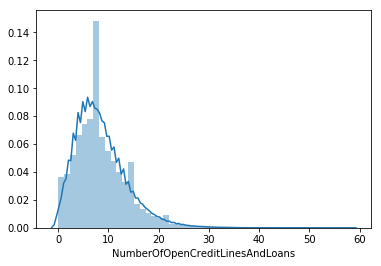

In [27]:
sns.distplot(training_dataset.NumberOfOpenCreditLinesAndLoans)

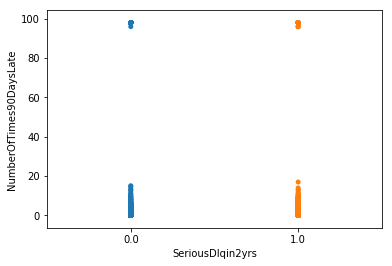

In [28]:
sns.stripplot(y="NumberOfTimes90DaysLate", x="SeriousDlqin2yrs", data=training_dataset);

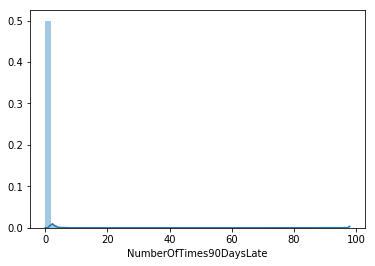

In [29]:
sns.distplot(training_dataset.NumberOfTimes90DaysLate)

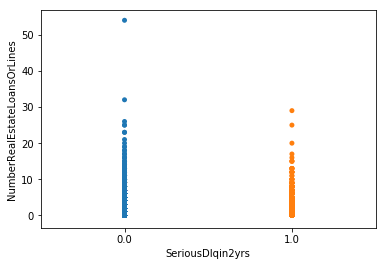

In [30]:
sns.stripplot(y="NumberRealEstateLoansOrLines", x="SeriousDlqin2yrs", data=training_dataset);

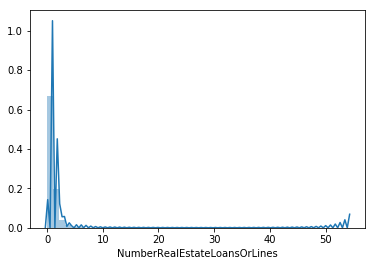

In [31]:
sns.distplot(training_dataset.NumberRealEstateLoansOrLines)

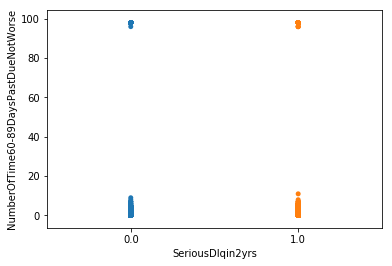

In [32]:
sns.stripplot(y="NumberOfTime60-89DaysPastDueNotWorse", x="SeriousDlqin2yrs", data=training_dataset);

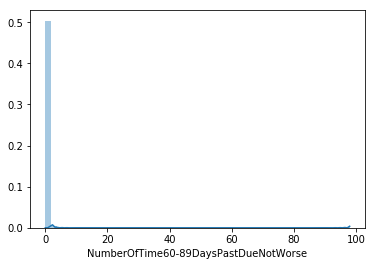

In [33]:
sns.distplot(training_dataset['NumberOfTime60-89DaysPastDueNotWorse'])

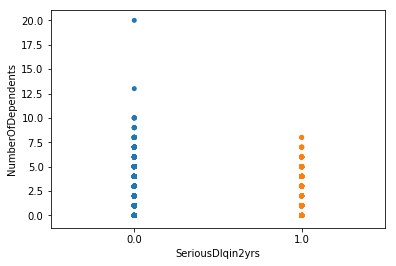

In [34]:
sns.stripplot(y="NumberOfDependents", x="SeriousDlqin2yrs", data=training_dataset);

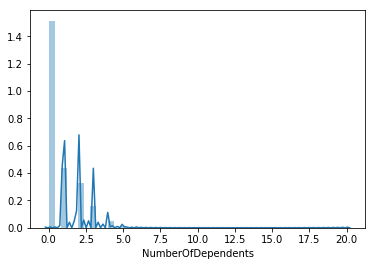

In [35]:
sns.distplot(training_dataset['NumberOfDependents'])

strip plot digunakan untuk  melihat penyebaran data suatu variabel terhadap kelas, dari hasil visualisasi di atas di ambil di dapat beberapa pengetahuan, yaitu :
* RevolvingUtilizationOfUnsecuredLines, nilai RevolvingUtilizationOfUnsecuredLines cenderung kecil jika konsumen default(1).
* Age, jumlah konsumen paling banyak yang mengajukan keredit berkisar antara umur 40 sampai 60 tahun.
* Konsumen yang defaulted memiliki DebtRatio dan MonthlyIncome yang kecil di banding yang tidak. 
* Jumlah Dependent Konsumen yang defaulted cenderung sedikit di banding yang tidak.

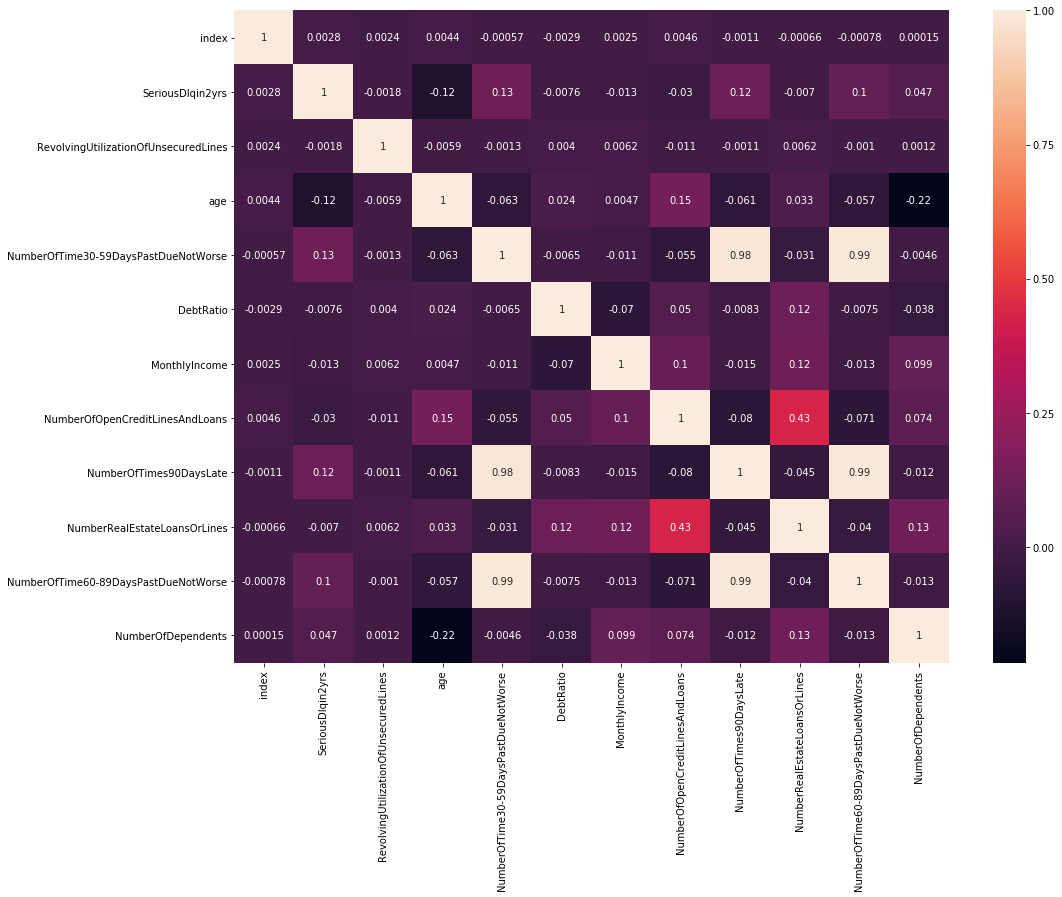

In [36]:
corr = training_dataset.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, fmt=".2g")

Dengan Heatmap didapat korelasi antar fitur terhadap fitur lainnya. contohnya fitur NumberOfDependents yang berpengaruh ke SeriousDlqin2yrs sebesar 0.046. Dalam hal ini yang harus di perhatikan ialah korelasi independent variable dengan dependent variabel

##### 1.5 Raw Testing
percobaan untuk data langsung dari dataset dengan penggunaan seluruh independent variabel yang ada di dalam dataset

In [37]:
X_Raw_Testing = ['RevolvingUtilizationOfUnsecuredLines', 'age','NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome','NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
X_train_raw = training_dataset[X_Raw_Testing].values
Y_train_raw = training_dataset[['SeriousDlqin2yrs']].values
X_train_raw, X_validation_raw, Y_train_raw, Y_validation_raw = train_test_split(X_train_raw,Y_train_raw, test_size = 0.2, random_state = 0)

In [38]:
raw_model = Sequential()
raw_model.add(Dense(units = 256, input_dim = X_train_raw.shape[1], activation = 'relu'))
raw_model.add(Dense(units = 256, activation = 'relu'))
raw_model.add(Dense(units = 128, activation = 'relu'))
raw_model.add(Dense(units = 128, activation = 'relu'))
raw_model.add(Dense(units = 1, activation = 'sigmoid'))
raw_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [39]:
log_raw_training = raw_model.fit(X_train_raw, Y_train_raw,batch_size= 4096, epochs=50, verbose=1, validation_data=(X_validation_raw, Y_validation_raw))  # starts training

Train on 119999 samples, validate on 30000 samples
Epoch 1/50
119999/119999 [==============================] - 4s 32us/step - loss: 3.4186 - acc: 0.7814 - val_loss: 1.0708 - val_acc: 0.9323
Epoch 2/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.1064 - acc: 0.9280 - val_loss: 1.0796 - val_acc: 0.9323
Epoch 3/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.0567 - acc: 0.9333 - val_loss: 1.0719 - val_acc: 0.9323
Epoch 4/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.0480 - acc: 0.9335 - val_loss: 1.0632 - val_acc: 0.9322
Epoch 5/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.1032 - acc: 0.9281 - val_loss: 1.0887 - val_acc: 0.9323
Epoch 6/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.0648 - acc: 0.9334 - val_loss: 1.0749 - val_acc: 0.9323
Epoch 7/50
119999/119999 [==============================] - 1s 9us/step - loss: 1.0510 - acc: 0.9334 - val_loss: 1.0688 

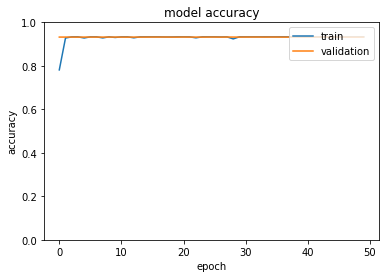

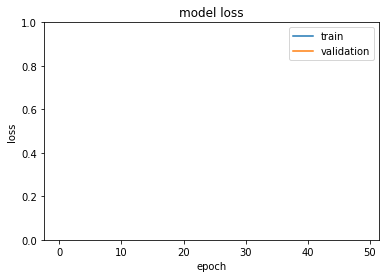

In [40]:
# summarize history for accuracy
plot_accuracy_against_epoch(log_raw_training)
# summarize history for loss
plot_loss_against_epoch(log_raw_training)

In [41]:
print(classification_report(Y_validation_raw, [np.round(pred) for pred in raw_model.predict(X_validation_raw)], labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.93      1.00      0.97     27969
          1       0.69      0.00      0.01      2031

avg / total       0.92      0.93      0.90     30000



In [42]:
print(confusion_matrix(Y_validation_raw, [np.round(pred) for pred in (raw_model.predict(X_validation_raw))]))

[[27965     4]
 [ 2022     9]]


Model yang dibangung dengan imbalanced data cenderung mengabaikan kelas yang non dominant dengan menganggap non dominant (kelas 1) sebagai noise atau outliners, hal ini terlihat dari hasil klasifikasi model yang tidak pernah menghasilkan prediksi yes (1). ini mengindikasikan model yang tidak baik karena ditraining dengan imbalanced data, walaupun menghasilkan akurasi tinggi (92.3 %). Selanjutnya dilakukan teknik sampling untuk membuat kelas data menjadi balanced dan diharapkan menghasilkan klasifikasi yang lebih baik

In [ ]:
#free some memory
del X_train_raw, X_validation_raw, Y_train_raw, Y_validation_raw

#### 1.6 Feature Engineering

##### Worker Status
Employment rates are shown for three age groups: people aged 15 to 24 (those just entering the labour market following education); people aged 25 to 54 (those in their prime working lives); people aged 55 to 64 (those passing the peak of their career and approaching retirement).

In [281]:
#Create Feature Worker Status
#Training Dataset
age = training_dataset['age'].values
new_age = []
pd_size = training_dataset.shape[0]
for i in range(age.shape[0]):
    if(age[i] > 15 and age[i] <= 24):
        new_age.append('new worker')
    elif (age[i] >= 25 and age[i] <= 54):
        new_age.append('prime worker')
    elif (age[i] >= 55 and age[i] <= 64):
        new_age.append('peak worker')
    elif (age[i] > 64):
        new_age.append('retired')
        
training_dataset['WorkerStatus'] = np.array(new_age)
label_encoder = LabelEncoder()
training_dataset['WorkerStatus'] = label_encoder.fit_transform(training_dataset['WorkerStatus'])
one_hot_encoder = OneHotEncoder()
temp = one_hot_encoder.fit_transform(training_dataset['WorkerStatus'].values.reshape([pd_size,1])).toarray()
temp = pd.DataFrame(temp)
training_dataset['NewWorker'] = temp.iloc[:,0]
training_dataset['PrimeWorker'] = temp.iloc[:,1]
training_dataset['PeakWorker'] = temp.iloc[:,2]
training_dataset['Retired'] = temp.iloc[:,3]

In [282]:
#Test Dataset
age = test_dataset['age'].values
new_age = []
pd_size = test_dataset.shape[0]
for i in range(age.shape[0]):
    if(age[i] > 15 and age[i] <= 24):
        new_age.append('new worker')
    elif (age[i] >= 25 and age[i] <= 54):
        new_age.append('prime worker')
    elif (age[i] >= 55 and age[i] <= 64):
        new_age.append('peak worker')
    elif (age[i] > 64):
        new_age.append('retired')
        
test_dataset['WorkerStatus'] = np.array(new_age)
label_encoder = LabelEncoder()
test_dataset['WorkerStatus'] = label_encoder.fit_transform(test_dataset['WorkerStatus'])
one_hot_encoder = OneHotEncoder()
temp = one_hot_encoder.fit_transform(test_dataset['WorkerStatus'].values.reshape([pd_size,1])).toarray()
temp = pd.DataFrame(temp)
test_dataset['NewWorker'] = temp.iloc[:,0]
test_dataset['PrimeWorker'] = temp.iloc[:,1]
test_dataset['PeakWorker'] = temp.iloc[:,2]
test_dataset['Retired'] = temp.iloc[:,3]

##### TotalNumberOfOpenCredit
Create Derived Feature from NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines as TotalNumberOfOpenCredit.
* NumberOfOpenCreditLinesAndLoans, is a Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards), A line of credit (LOC) is an arrangement between a financial institution, usually a bank, and a customer, that established the maximum amount of a loan that the customer can borrow. The borrower can access funds from the line of credit at any time, as long as he or she does not exceed the maximum amount set in the agreement and meets any other requirements, such as making timely minimum payments
* NumberRealEstateLoansOrLines, Number of mortgage and real estate loans including home equity lines of credit
this feature is merged which results in an overall bill charged to the consumer


In [283]:
#Training Dataset
TotalNumberOfOpenCredit = training_dataset['NumberOfOpenCreditLinesAndLoans'] + training_dataset['NumberRealEstateLoansOrLines']
training_dataset['TotalNumberOfOpenCredit'] = TotalNumberOfOpenCredit

In [284]:
#Test Dataset
TotalNumberOfOpenCredit = test_dataset['NumberOfOpenCreditLinesAndLoans'] + test_dataset['NumberRealEstateLoansOrLines']
test_dataset['TotalNumberOfOpenCredit'] = TotalNumberOfOpenCredit

##### TotalNumberOfTime
Create Derived Feature from NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate as Total Number Past Due Not Worse

In [285]:
#Training Dataset
TotalNumberOfTime = training_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + training_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + training_dataset['NumberOfTimes90DaysLate']
training_dataset['TotalNumberOfTime'] = TotalNumberOfTime

In [286]:
#Test Dataset
TotalNumberOfTime = test_dataset['NumberOfTime30-59DaysPastDueNotWorse'] + test_dataset['NumberOfTime60-89DaysPastDueNotWorse'] + test_dataset['NumberOfTimes90DaysLate']
test_dataset['TotalNumberOfTime'] = TotalNumberOfTime

##### IsDefaulted

Create Derived Feature that flag if customer ever defaulted.

In [287]:
#Training Dataset
training_dataset["IsDefaulted"] = training_dataset["NumberOfTimes90DaysLate"] + training_dataset["NumberOfTime60-89DaysPastDueNotWorse"]+ training_dataset["NumberOfTime30-59DaysPastDueNotWorse"]
training_dataset.loc[(training_dataset["IsDefaulted"] >= 1), "IsDefaulted"] = 1

In [288]:
#Test Dataset
test_dataset["IsDefaulted"] = test_dataset["NumberOfTimes90DaysLate"] + test_dataset["NumberOfTime60-89DaysPastDueNotWorse"]+ test_dataset["NumberOfTime30-59DaysPastDueNotWorse"]
test_dataset.loc[(test_dataset["IsDefaulted"] >= 1), "IsDefaulted"] = 1

In [289]:
training_dataset.head(10)

,index,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,WorkerStatus,NewWorker,PrimeWorker,PeakWorker,Retired,TotalNumberOfOpenCredit,TotalNumberOfTime,IsDefaulted
0,0,1.0,-0.021150,45.0,2.0,-0.172834,0.286747,13.0,0.0,6.0,0.0,2.0,2,0.0,0.0,1.0,0.0,19.0,2.0,1.0
1,1,0.0,-0.020385,40.0,0.0,-0.173168,-0.209003,4.0,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,0.0,4.0,0.0,0.0
2,2,0.0,-0.021582,38.0,1.0,-0.173186,-0.175395,2.0,1.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,2.0,2.0,1.0
3,3,0.0,-0.023281,30.0,0.0,-0.173210,-0.155778,5.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,5.0,0.0,0.0
4,4,0.0,-0.020585,49.0,1.0,-0.173216,4.428232,7.0,0.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,8.0,1.0,1.0
5,5,0.0,-0.023364,74.0,0.0,-0.173044,-0.140571,3.0,0.0,1.0,0.0,1.0,3,0.0,0.0,0.0,1.0,4.0,0.0,0.0
6,6,0.0,-0.022994,57.0,0.0,2.628788,-0.406517,8.0,0.0,3.0,0.0,0.0,1,0.0,1.0,0.0,0.0,11.0,0.0,0.0
7,7,0.0,-0.021197,39.0,0.0,-0.173125,-0.140571,8.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,8.0,0.0,0.0
8,8,0.0,-0.023749,27.0,0.0,-0.150655,-0.406572,2.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,2.0,0.0,0.0
9,9,0.0,-0.023460,57.0,0.0,-0.172931,1.394124,9.0,0.0,4.0,0.0,2.0,1,0.0,1.0,0.0,0.0,13.0,0.0,0.0


In [290]:
test_dataset.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,WorkerStatus,NewWorker,PrimeWorker,PeakWorker,Retired,TotalNumberOfOpenCredit,TotalNumberOfTime,IsDefaulted
0,NaN,-0.020672,43.0,0.0,-0.173141,0.026707,4.0,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,4.0,0.0,0.0
1,NaN,-0.022363,57.0,0.0,-0.172969,0.288344,15.0,0.0,4.0,0.0,2.0,1,0.0,1.0,0.0,0.0,19.0,0.0,0.0
2,NaN,-0.024044,59.0,0.0,-0.172891,-0.020207,12.0,0.0,1.0,0.0,2.0,1,0.0,1.0,0.0,0.0,13.0,0.0,0.0
3,NaN,-0.023095,38.0,1.0,-0.172774,-0.163381,7.0,0.0,2.0,0.0,0.0,2,0.0,0.0,1.0,0.0,9.0,1.0,1.0
4,NaN,-0.020214,27.0,0.0,-0.173218,-0.112818,4.0,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,0.0,4.0,0.0,0.0
5,NaN,-0.022176,63.0,0.0,-0.173060,-0.091908,4.0,0.0,0.0,0.0,1.0,1,0.0,1.0,0.0,0.0,4.0,0.0,0.0
6,NaN,-0.021864,50.0,0.0,0.341047,-0.406694,5.0,0.0,0.0,0.0,3.0,2,0.0,0.0,1.0,0.0,5.0,0.0,0.0
7,NaN,-0.024033,79.0,1.0,-0.173047,-0.155702,8.0,0.0,1.0,0.0,1.0,3,0.0,0.0,0.0,1.0,9.0,1.0,1.0
8,NaN,-0.024163,68.0,0.0,0.819991,-0.406639,4.0,0.0,1.0,0.0,0.0,3,0.0,0.0,0.0,1.0,5.0,0.0,0.0
9,NaN,-0.020214,23.0,98.0,-0.173228,-0.406694,0.0,98.0,0.0,98.0,0.0,0,1.0,0.0,0.0,0.0,0.0,294.0,1.0


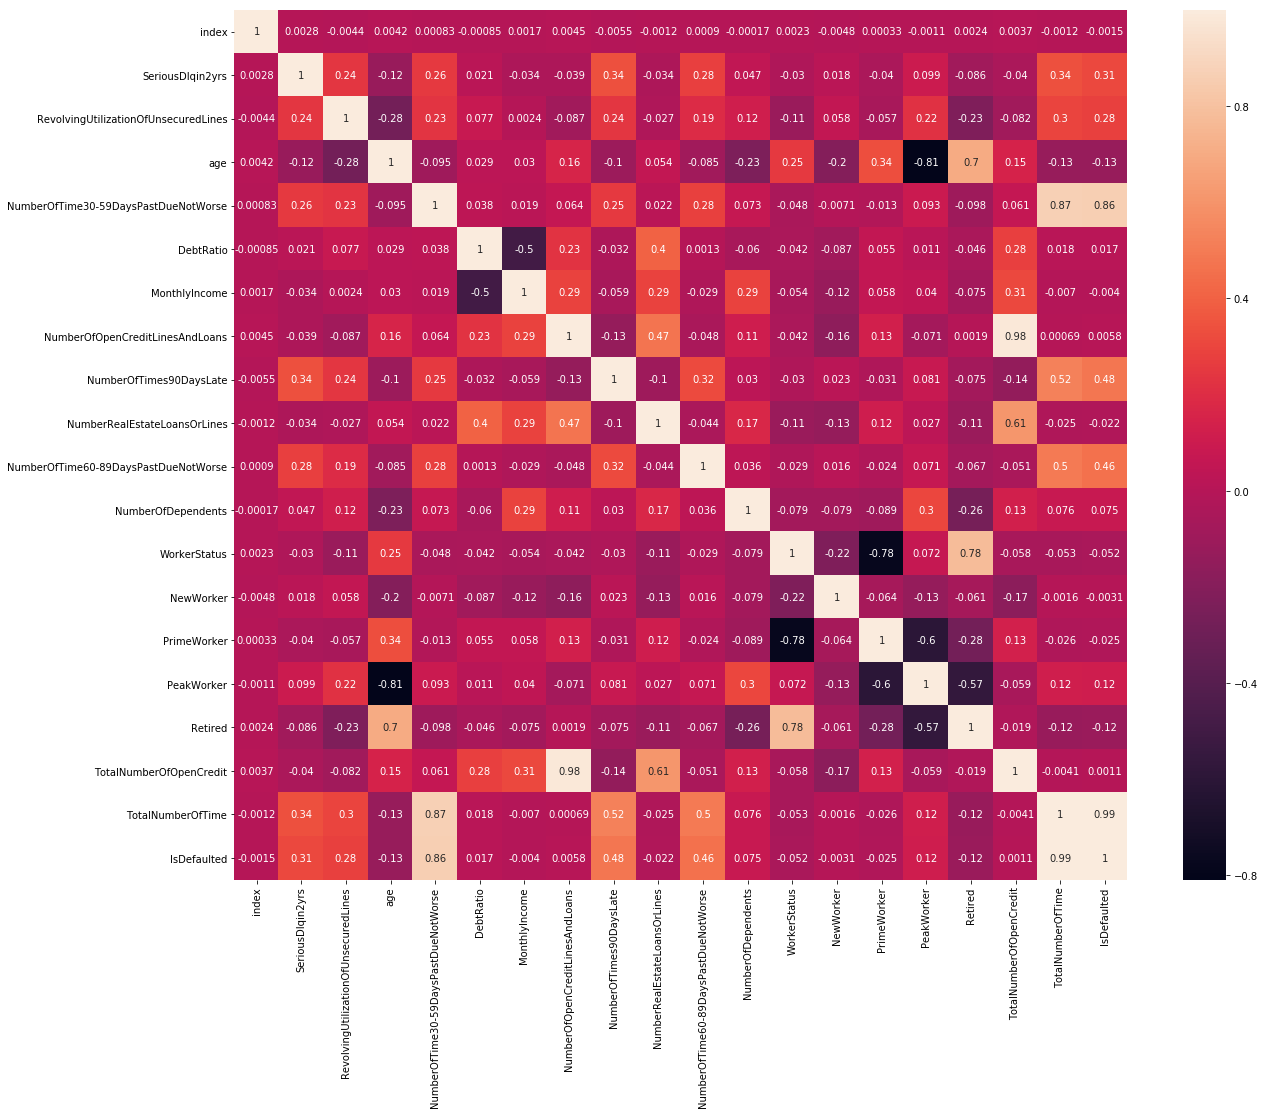

In [48]:
corr = training_dataset.corr(method='spearman')
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True, fmt=".2g")

In [276]:
scaler = StandardScaler()
training_dataset['RevolvingUtilizationOfUnsecuredLines'] = scaler.fit_transform(training_dataset['RevolvingUtilizationOfUnsecuredLines'].values.reshape([training_dataset.values.shape[0],-1]))
test_dataset['RevolvingUtilizationOfUnsecuredLines'] = scaler.transform(test_dataset['RevolvingUtilizationOfUnsecuredLines'].values.reshape([test_dataset.values.shape[0],-1]))
scaler = StandardScaler()
training_dataset['DebtRatio'] = scaler.fit_transform(training_dataset['DebtRatio'].values.reshape([training_dataset.values.shape[0],-1]))
test_dataset['DebtRatio'] = scaler.transform(test_dataset['DebtRatio'].values.reshape([test_dataset.values.shape[0],-1]))
scaler = StandardScaler()
training_dataset['MonthlyIncome'] = scaler.fit_transform(training_dataset['MonthlyIncome'].values.reshape([training_dataset.values.shape[0],-1]))
test_dataset['MonthlyIncome'] = scaler.transform(test_dataset['MonthlyIncome'].values.reshape([test_dataset.values.shape[0],-1]))

In [277]:
training_dataset.columns

Index(['index', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'],
      dtype='object')

In [278]:
test_dataset.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [291]:
#Training
X = ['DebtRatio','NumberOfDependents','NewWorker','PeakWorker','IsDefaulted','TotalNumberOfTime','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']
X_train = training_dataset[X].values
Y_train = training_dataset[['SeriousDlqin2yrs']].values
#X_test = test_dataset[X].values
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,Y_train, test_size = 0.2, random_state = 0)

In [292]:
#Test
X = ['DebtRatio','NumberOfDependents','NewWorker','PeakWorker','IsDefaulted','TotalNumberOfTime','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines']
X_test = test_dataset[X].values

##### Oversampling Data

In [54]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_oversampling, Y_train_oversampling = sm.fit_sample(X_train, Y_train)
calculate_num_of_class(Y_train_oversampling)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Count Labels : 1 = 112004
Count Labels : 0 = 112004


##### Undersampling Data

In [304]:
randomUnderSampler = RandomUnderSampler(random_state = 12)
X_train_undersampling, Y_train_undersampling = randomUnderSampler.fit_sample(X_train, Y_train)
calculate_num_of_class(Y_train_undersampling)

Count Labels : 1 = 7995
Count Labels : 0 = 7995


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Undersampling and Oversampling Data

In [56]:
smooten = SMOTETomek(random_state = 12)
X_train_combinesampling, Y_train_combinesampling = smooten.fit_sample(X_train, Y_train)
calculate_num_of_class(Y_train_combinesampling)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Count Labels : 1 = 102361
Count Labels : 0 = 102361


##### 1.7 Sampling Testing

##### Testing Dataset Sampling Using ANN

In [83]:
under_model = Sequential()
under_model.add(Dense(units = 256, input_dim = X_train_undersampling.shape[1], activation = 'relu'))
under_model.add(Dense(units = 256, input_dim = X_train_undersampling.shape[1], activation = 'relu'))
under_model.add(Dense(units = 256, activation = 'relu'))
under_model.add(Dense(units = 128, activation = 'relu'))
under_model.add(Dense(units = 128, activation = 'relu'))
under_model.add(Dense(units = 1, activation = 'sigmoid'))
under_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [84]:
log_undersampling = under_model.fit(X_train_undersampling, Y_train_undersampling,batch_size= 4096, epochs=50, verbose=1, validation_data=(X_validation, Y_validation))  # starts training

Train on 15990 samples, validate on 30000 samples
Epoch 1/50
15990/15990 [==============================] - 1s 81us/step - loss: 0.6859 - acc: 0.6577 - val_loss: 0.7072 - val_acc: 0.7909
Epoch 2/50
15990/15990 [==============================] - 0s 18us/step - loss: 0.6005 - acc: 0.7502 - val_loss: 0.7045 - val_acc: 0.8260
Epoch 3/50
15990/15990 [==============================] - 0s 19us/step - loss: 0.5702 - acc: 0.7532 - val_loss: 0.6193 - val_acc: 0.8277
Epoch 4/50
15990/15990 [==============================] - 0s 18us/step - loss: 0.5564 - acc: 0.7540 - val_loss: 0.6140 - val_acc: 0.8256
Epoch 5/50
15990/15990 [==============================] - 0s 19us/step - loss: 0.5470 - acc: 0.7553 - val_loss: 0.5622 - val_acc: 0.8253
Epoch 6/50
15990/15990 [==============================] - 0s 19us/step - loss: 0.5350 - acc: 0.7557 - val_loss: 0.5485 - val_acc: 0.8256
Epoch 7/50
15990/15990 [==============================] - 0s 18us/step - loss: 0.5264 - acc: 0.7555 - val_loss: 0.5656 - val_acc

In [85]:
over_model = Sequential()
over_model.add(Dense(units = 256, input_dim = X_train_oversampling.shape[1], activation = 'relu'))
over_model.add(Dense(units = 256, activation = 'relu'))
over_model.add(Dense(units = 128, activation = 'relu'))
over_model.add(Dense(units = 128, activation = 'relu'))
over_model.add(Dense(units = 1, activation = 'sigmoid'))
over_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [86]:
log_oversampling = over_model.fit(X_train_oversampling, Y_train_oversampling,batch_size= 4096, epochs=50, verbose=1, validation_data=(X_validation, Y_validation))  # starts training

Train on 224008 samples, validate on 30000 samples
Epoch 1/50
224008/224008 [==============================] - 3s 13us/step - loss: 0.5475 - acc: 0.7404 - val_loss: 0.4965 - val_acc: 0.8254
Epoch 2/50
224008/224008 [==============================] - 2s 8us/step - loss: 0.5202 - acc: 0.7540 - val_loss: 0.5209 - val_acc: 0.8369
Epoch 3/50
224008/224008 [==============================] - 2s 9us/step - loss: 0.5185 - acc: 0.7545 - val_loss: 0.5008 - val_acc: 0.8399
Epoch 4/50
224008/224008 [==============================] - 2s 9us/step - loss: 0.5179 - acc: 0.7549 - val_loss: 0.5070 - val_acc: 0.8424
Epoch 5/50
224008/224008 [==============================] - 2s 9us/step - loss: 0.5176 - acc: 0.7550 - val_loss: 0.4892 - val_acc: 0.8482
Epoch 6/50
224008/224008 [==============================] - 2s 9us/step - loss: 0.5175 - acc: 0.7550 - val_loss: 0.4995 - val_acc: 0.8434
Epoch 7/50
224008/224008 [==============================] - 2s 9us/step - loss: 0.5171 - acc: 0.7553 - val_loss: 0.5150 

In [61]:
combine_model = Sequential()
combine_model.add(Dense(units = 256, input_dim = X_train_combinesampling.shape[1], activation = 'relu'))
combine_model.add(Dense(units = 256, activation = 'relu'))
combine_model.add(Dense(units = 128, activation = 'relu'))
combine_model.add(Dense(units = 128, activation = 'relu'))
combine_model.add(Dense(units = 1, activation = 'sigmoid'))
combine_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [62]:
log_combinesampling = combine_model.fit(X_train_combinesampling, Y_train_combinesampling,batch_size= 4096, epochs=50, verbose=1, validation_data=(X_validation, Y_validation))  # starts training

Train on 204722 samples, validate on 30000 samples
Epoch 1/50
204722/204722 [==============================] - 3s 12us/step - loss: 0.5242 - acc: 0.7686 - val_loss: 0.5094 - val_acc: 0.8255
Epoch 2/50
204722/204722 [==============================] - 2s 8us/step - loss: 0.4874 - acc: 0.7780 - val_loss: 0.5136 - val_acc: 0.8397
Epoch 3/50
204722/204722 [==============================] - 2s 8us/step - loss: 0.4857 - acc: 0.7785 - val_loss: 0.4987 - val_acc: 0.8438
Epoch 4/50
204722/204722 [==============================] - 2s 9us/step - loss: 0.4848 - acc: 0.7787 - val_loss: 0.4862 - val_acc: 0.8281
Epoch 5/50
204722/204722 [==============================] - 2s 8us/step - loss: 0.4841 - acc: 0.7792 - val_loss: 0.5097 - val_acc: 0.8433
Epoch 6/50
204722/204722 [==============================] - 2s 8us/step - loss: 0.4838 - acc: 0.7793 - val_loss: 0.5201 - val_acc: 0.8277
Epoch 7/50
204722/204722 [==============================] - 2s 9us/step - loss: 0.4838 - acc: 0.7793 - val_loss: 0.5241 

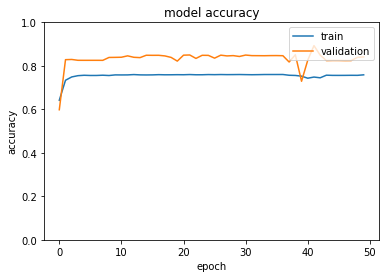

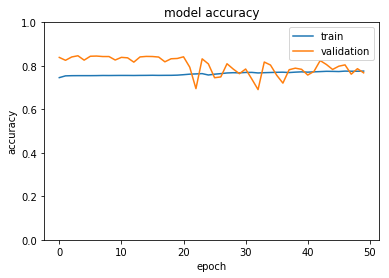

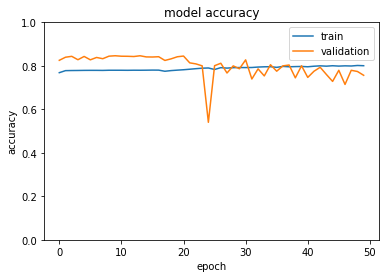

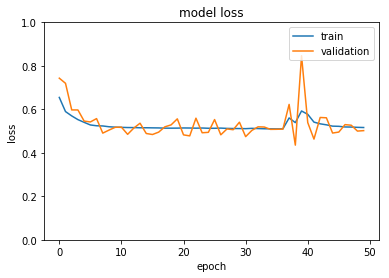

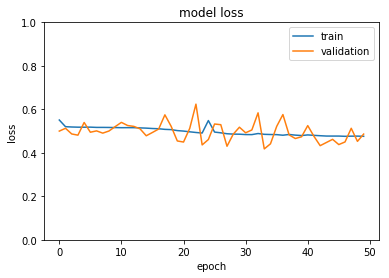

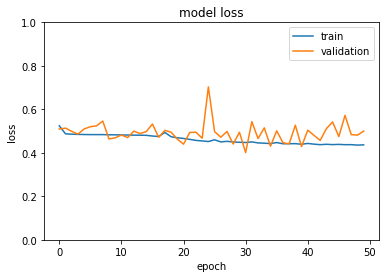

In [63]:
# summarize history for accuracy
plot_accuracy_against_epoch(log_undersampling)
plot_accuracy_against_epoch(log_oversampling)
plot_accuracy_against_epoch(log_combinesampling)
# summarize history for loss
plot_loss_against_epoch(log_undersampling)
plot_loss_against_epoch(log_oversampling)
plot_loss_against_epoch(log_combinesampling)

Dari hasil training model dengan teknik sampling yang berbeda, didapat kesimpulan teknik sampling yang cocok untuk dataset ini. model yang di gunakan merupakan model neural network dengan konfigurasi hyperparameter:
* 4 hidden layers
* Relu Activation Function
* Adam Optimizer with Learning Rate = 0.01
* Number of Epoch = 50
* Batch Size = 4096
* Sigmoid as Output Activation Function
* Number of Units berturut turut = [256, 256, 128, 128]

Data hasil Training :
* Under Sampling, loss: loss: 0.5004 - acc: 0.7759 - val_loss: 0.5003 - val_acc: 0.7753
* Over Sampling, loss: loss: 0.4916 - acc: 0.7735 - val_loss: 0.4825 - val_acc: 0.7754
* Combine Sampling, loss: 0.4176 - acc: 0.8174 - val_loss: 0.4546 - val_acc: 0.7887

##### Undersampling Accuracy

In [87]:
print(classification_report(Y_validation, [np.round(pred) for pred in under_model.predict(X_validation)], labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.97      0.86      0.91     27969
          1       0.25      0.64      0.36      2031

avg / total       0.92      0.85      0.87     30000



In [88]:
print(confusion_matrix(Y_validation, [np.round(pred) for pred in under_model.predict(X_validation)]))

[[24077  3892]
 [  737  1294]]


##### Oversampling Accuracy

In [89]:
print(classification_report(Y_validation, [np.round(pred) for pred in over_model.predict(X_validation)], labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.81      0.89     27969
          1       0.22      0.73      0.34      2031

avg / total       0.93      0.81      0.85     30000



In [90]:
print(confusion_matrix(Y_validation, [np.round(pred) for pred in over_model.predict(X_validation)]))

[[22754  5215]
 [  540  1491]]


##### Combine Sampling Accuracy

In [64]:
print(classification_report(Y_validation, [np.round(pred) for pred in combine_model.predict(X_validation)], labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.75      0.85     27969
          1       0.19      0.79      0.31      2031

avg / total       0.93      0.76      0.82     30000



In [65]:
print(confusion_matrix(Y_validation, [np.round(pred) for pred in combine_model.predict(X_validation)]))

[[21090  6879]
 [  424  1607]]


Setelah di bandingkan loss dan accuracy kemudian dibandingkan setiap model dengan akurasi yang lebih mendalam, di mana akurasi yang di pertimbangkan meliputi precision, recall dan f1-score. di simpulkan metode sampling yang paling baik ialah under sampling, selanjutnya dataset yang di hasilkan dengan undersampling yang akan di gunakan untuk melatih model.

In [ ]:
#Free some memory
del X_train_combinesampling, Y_train_combinesampling, X_train_oversampling, Y_train_oversampling
del under_model, over_model, combine_model

##### Training

##### 2.1 Support Vector Machine

In [93]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_undersampling, Y_train_undersampling)
SVC_predict = svc.predict(X_validation)

In [94]:
print(classification_report(Y_validation, SVC_predict, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.97      0.84      0.90     27969
          1       0.23      0.66      0.34      2031

avg / total       0.92      0.82      0.86     30000



In [95]:
print(confusion_matrix(Y_validation, SVC_predict))
del SVC_predict

[[23395  4574]
 [  693  1338]]


##### 2.2 Gradient Boosting Classifier

In [96]:
from sklearn.ensemble import GradientBoostingClassifier
gradientBoostingClassifier = GradientBoostingClassifier()
gradientBoostingClassifier.fit(X_train_undersampling, Y_train_undersampling)
gradient_boosting_predict = gradientBoostingClassifier.predict(X_validation)

In [97]:
print(classification_report(Y_validation, gradient_boosting_predict, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.79      0.88     27969
          1       0.21      0.77      0.34      2031

avg / total       0.93      0.79      0.84     30000



In [98]:
print(confusion_matrix(Y_validation, gradient_boosting_predict))
del gradient_boosting_predict

[[22199  5770]
 [  457  1574]]


##### 2.3 Random Forest Classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier = RandomForestClassifier(random_state=42,n_estimators=300, max_depth=5, class_weight="balanced")
RandomForestClassifier.fit(X_train_undersampling, Y_train_undersampling)
random_forest_predict = RandomForestClassifier.predict(X_validation)

In [100]:
print(classification_report(Y_validation, random_forest_predict, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.80      0.88     27969
          1       0.21      0.76      0.33      2031

avg / total       0.93      0.79      0.84     30000



In [101]:
print(confusion_matrix(Y_validation, random_forest_predict))
del random_forest_predict

[[22283  5686]
 [  493  1538]]


##### 2.4 XGBoost

In [105]:
from xgboost import XGBClassifier
xgboostClassifier = XGBClassifier()
xgboostClassifier.fit(X_train_undersampling, Y_train_undersampling)

In [319]:
xgboost_predict = [np.round(pred) for pred in xgboostClassifier.predict(X_validation)]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [320]:
print(classification_report(Y_validation, xgboost_predict, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.80      0.88     27969
          1       0.22      0.76      0.34      2031

avg / total       0.93      0.80      0.84     30000



In [321]:
print(confusion_matrix(Y_validation, xgboost_predict))
del xgboost_predict

[[22344  5625]
 [  480  1551]]


##### 2.5 AdaBoost

In [111]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = AdaBoostClassifier(n_estimators=300, random_state=42)
adaBoostClassifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME", n_estimators=200)
adaBoostClassifier.fit(X_train_undersampling, Y_train_undersampling)
adaboost_predict = adaBoostClassifier.predict(X_validation)

In [112]:
print(classification_report(Y_validation, adaboost_predict, labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.98      0.81      0.88     27969
          1       0.22      0.76      0.34      2031

avg / total       0.93      0.80      0.85     30000



In [113]:
print(confusion_matrix(Y_validation, adaboost_predict))
del adaboost_predict

[[22564  5405]
 [  494  1537]]


##### 2.6 DNN

In [305]:
deep_neural_network = Sequential()
deep_neural_network.add(Dense(units = 512, input_dim = X_train_undersampling.shape[1], activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 512, activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 512, activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 512, activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 256, activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 256, activation = 'sigmoid'))
deep_neural_network.add(Dense(units = 1, activation = 'sigmoid'))
deep_neural_network.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [313]:
deep_neural_network.fit(X_train_undersampling, Y_train_undersampling,batch_size= 4096, epochs=50, verbose=1, validation_data=(X_validation, Y_validation))  # starts training

Train on 15990 samples, validate on 30000 samples
Epoch 1/50
15990/15990 [==============================] - 1s 55us/step - loss: 0.6789 - acc: 0.7178 - val_loss: 0.6576 - val_acc: 0.8793
Epoch 2/50
15990/15990 [==============================] - 1s 53us/step - loss: 0.6490 - acc: 0.7231 - val_loss: 0.6252 - val_acc: 0.8226
Epoch 3/50
15990/15990 [==============================] - 1s 55us/step - loss: 0.5773 - acc: 0.7490 - val_loss: 0.5294 - val_acc: 0.8220
Epoch 4/50
15990/15990 [==============================] - 1s 53us/step - loss: 0.5411 - acc: 0.7526 - val_loss: 0.5006 - val_acc: 0.8248
Epoch 5/50
15990/15990 [==============================] - 1s 53us/step - loss: 0.5567 - acc: 0.7546 - val_loss: 0.5449 - val_acc: 0.8255
Epoch 6/50
15990/15990 [==============================] - 1s 53us/step - loss: 0.5383 - acc: 0.7478 - val_loss: 0.6279 - val_acc: 0.8253
Epoch 7/50
15990/15990 [==============================] - 1s 53us/step - loss: 0.5380 - acc: 0.7525 - val_loss: 0.4880 - val_acc

In [327]:
deep_neural_network_predict = deep_neural_network.predict(X_validation)

In [328]:
print(classification_report(Y_validation, [np.round(pred) for pred in deep_neural_network_predict], labels=[0, 1]))

             precision    recall  f1-score   support

          0       0.97      0.87      0.92     27969
          1       0.26      0.63      0.36      2031

avg / total       0.92      0.85      0.88     30000



In [329]:
print(confusion_matrix(Y_validation, [np.round(pred) for pred in deep_neural_network_predict]))

[[24231  3738]
 [  749  1282]]


In [330]:
deep_neural_network_predict

array([[0.15875794],
       [0.15837742],
       [0.16077802],
       ...,
       [0.30778873],
       [0.62532663],
       [0.3077818 ]], dtype=float32)

From the training results in a suitable algorithm, which is artificial neural network. Furthermore, the model of DNN is used to determine the classification of consumers.

##### Classification

In [387]:
Y_predict = deep_neural_network.predict(X_test)
Y_predict.shape

(101503, 1)

In [389]:
Y_predict = pd.DataFrame(Y_predict)
Y_predict.shape

(101503, 1)

In [390]:
Y_predict['Id'] = range(1, len(Y_predict) + 1)

In [391]:
Y_predict['probability'] = Y_predict.iloc[:,[0]]

In [392]:
Y_predict = Y_predict.iloc[:,1:]

In [396]:
Y_predict.to_csv('datasets/submission.csv', index = False)